In [5]:
%run -i make_matrices
display(player_types)
display(players)

Matrix creation complete


In [3]:
%%time
from helper.setup import *

simulation_method = "parallel"
gridDims = (2**10,1,1)
blockDims = (1024,1,1)


# simulation_method = "serial"
# gridDims = (2**2,1,1)
# blockDims = (128,1,1)

sample_size = 2**10
print_level = 0

%run -i initialize.py

dir = "./"+simulation_method+"/"
setter = dir+"simulation_setup.py"
simulator = dir+"simulate.py"

def goodness(scores):
    x_bars = scores.mean(axis=0)
    return x_bars.mean()

%run -i $setter

Simulation setup complete
CPU times: user 328 ms, sys: 232 ms, total: 560 ms
Wall time: 688 ms


I did 1000 steps, simulating 1048576 games each time.  Best runs/game was 8.792 at step 796 with lineup:


,bat_ave
Parker,344.582
Gerardo,315.828
Jeanne,315.403
Taylor,292.575
Adam,295.557
Bobby,271.144
Mikaela,273.009
David,271.037
Mary,298.007
Joseph,261.332


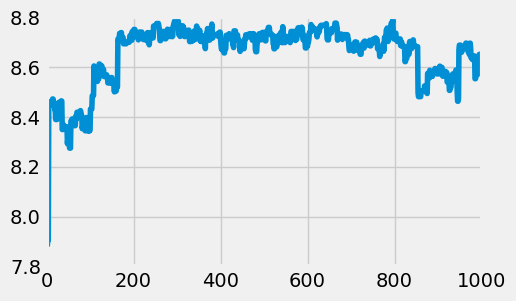

CPU times: user 1min 1s, sys: 8.28 s, total: 1min 9s
Wall time: 1min 9s


In [4]:
%%time
num_steps = 1000
L = 200

num_players = players.shape[0]
#lineup = np.random.permutation(np.arange(num_players)).astype('uint8')
lineup = np.arange(num_players).astype('uint8')

%run -i $simulator

good_current = goodness(scores)
good_best = good_current
lineup_best = lineup.copy()
step_best = 0

good_history = np.zeros(num_steps)
for step in range(num_steps):
    p0 = np.random.randint(9)
    p1 = p0
    while(p1 == p0):
        p1 = np.random.randint(num_players)
    lineup[p0], lineup[p1] = lineup[p1], lineup[p0]
    
    %run -i $simulator
    good_proposed = goodness(scores)
    
    delta_good = good_proposed - good_current
    if delta_good >= 0:
        #proposed is better than current.  Accept.
        move = "accept better"
        good_current = good_proposed.copy()
        if good_current > good_best:
            #check if best
            good_best = good_current
            lineup_best = lineup.copy()
            step_best = step
    else:
        #proposed is worse than current        
        r = np.random.rand()
        a = np.exp(L*(delta_good/good_current))
        if r < a:
            #accept worse
            move = "accept worse"            
            good_current = good_proposed.copy()
        else:
            #reject worse
            move = "reject worse"            
            lineup[p0], lineup[p1] = lineup[p1], lineup[p0]
    
    good_history[step] = good_current.copy()
    #print(move)

print("I did %d steps, simulating %d games each time.  Best runs/game was %.3f at step %d with lineup:"
      %(step+1, num_sims, good_best, step_best))
display(players.ix[lineup_best,'bat_ave'])
plt.plot(good_history)
plt.show()